# Differentiable Categorical/One-Hot Encoding

Both the original [Wavenet paper](https://arxiv.org/pdf/1609.03499.pdf) and the [SampleRNN paper](https://arxiv.org/abs/1612.07837) somewhat surprisingly use a softmax/categorical distribution to model audio, despite the fact that audio samples are real-valued/continuous.  

The motivation for this is that a categorical distribution is very flexible, and can ultimately model any arbitrary (and arbitrarily complex) distribution, as it makes no a priori assumptions about the shape of the distribution, as we would if were assuming a gaussian distribution, or even a mixture of logistics.

Ultimately, a discretized mixture of logistics is what the group working on wavenet end up using in the [Parallel Wavenet paper](https://arxiv.org/abs/1711.10433), inspired by improvements to a related auto-regressive model for image generation, [PixelCNN++](https://openreview.net/pdf?id=BJrFC6ceg).  

This approach affords a more compact, memory-efficient encoding, and hence allows the parallel wavenet folks to improve the "bit-depth" of their model from 8 to 16 bits.

While I'm interested in exploring the discretized mixture of logistics, I'm intrigued by the success of these original categorical models in producing relatively crisp, clean audio.  My experience so far modelling audio as real-valued and continous has resulted in clearly audible structure, but lots and lots of noise.

One experiment I'm interested in running involves a generative adversarial network setup where the generator continues to produce real-valued samples, while the discriminator/critic performs its own differentiable one-hot encoding and embedding of the incoming samples.  PyTorch has an [embedding layer](http://pytorch.org/docs/master/nn.html#torch.nn.Embedding), but you can only compute gradients and backpropagate through its embedding weights, so bolting it to the front of a discriminator/critic is a no-go, as the gradients have to flow all the way back into the generator.

The natural approach to a one-hot encoding in, say, numpy would be to produce an array of shape `(samples, categories)`, and assign ones to indices along the second axis, but, this wouldn't permit backpropagation.

[Section 3.4 of End-to-End Learning of Geometry and Context for Deep Stereo Regression](https://arxiv.org/pdf/1703.04309.pdf) about a soft, differentiable argmin function got me thinking about how to do something similar with index assignment.

## Load Some Audio

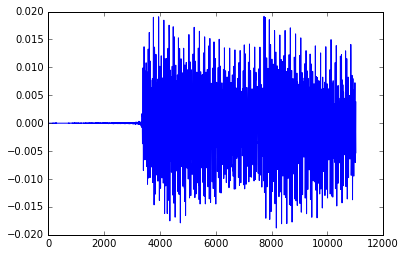

In [39]:
%matplotlib inline
from IPython.display import display, Audio
from matplotlib import pyplot as plt
from zounds import AudioSamples, SR11025, Seconds
from zounds.soundfile import resample

samples = AudioSamples.from_file('../audio/bach.ogg').mono[:Seconds(1)]
samples = resample(samples, SR11025())
plt.plot(samples)
Audio(samples, rate=int(samples.samplerate))

## The Pipeline

Our module will apply the following transformations to raw audio samples:
1. [mu-law compression](https://en.wikipedia.org/wiki/%CE%9C-law_algorithm), as is done in the wavenet paper
1. shift and scale the signal so that it falls in the interval `[0 - n_categories]`
1. one-hot encode each sample

In [57]:
from torch import nn
import torch
from torch.autograd import Variable
from torch.nn import functional as F

class RawSampleEmbedding(nn.Module):
    """
    Embed raw audio samples after discretizing them and
    applying a softmax/categorical distribution
    """
    
    def __init__(self, n_categories, embedding_dim):
        super(RawSampleEmbedding, self).__init__()
        self.n_categories = n_categories
        self.embedding_dim = embedding_dim
        self.linear = nn.Linear(
            self.n_categories, self.embedding_dim)
    
    def _mu_law(self, x):
        m = Variable(torch.FloatTensor(1))
        m[:] = self.n_categories + 1
        s = torch.sign(x)
        x = torch.abs(x)
        x = s * (torch.log(1 + (self.n_categories * x)) / torch.log(m))
        return x

    def _shift_and_scale(self, x):
        x = x + 1
        x = x * ((self.n_categories + 1) / 2.)
        return x
    
    def _one_hot(self, x):
        y = Variable(torch.arange(0, self.n_categories + 1))
        x = -(((x[..., None] - y) ** 2) * 1e12)
        x = F.softmax(x, dim=-1)
        return x

    def categorical(self, x):
        x = x.view(-1)
        x = self._mu_law(x)
        x = self._shift_and_scale(x)
        x = self._one_hot(x)
        return x

    def forward(self, x):
        
        # one-hot encode the continuous samples
        x = self.categorical(x)

        # embed the categorical variables into a 
        # dense vector
        x = self.linear(x)

        # place all embeddings on the unit sphere
        norms = torch.norm(x, dim=-1)
        x = x / norms.view(-1, 1)
        x = x.view(-1, self.embedding_dim, sample_size)
        return x

The embedding weights are a learnable parameter, so we won't spend any time poking at that.  

Let's make sure we can at least recover the original audio samples from the categorical encoding.

First, let's visually inspect the one-hot encoding:

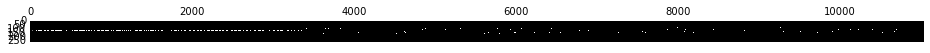

In [58]:
# reshape to the follow the PyTorch convention of (samples x channels x width)
batch_samples = samples.reshape((1, 1, samples.size))
batch_samples = Variable(torch.from_numpy(batch_samples).float())

embedding = RawSampleEmbedding(256, 3)

one_hot = embedding.categorical(batch_samples)
one_hot = one_hot.data.cpu().numpy()

plt.matshow(one_hot.T, cmap='gray')

Then, let's recover the samples, and give them a listen.

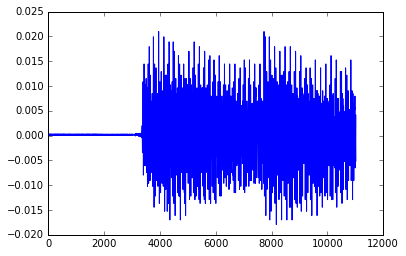

In [59]:
import numpy as np
from zounds.loudness import inverse_mu_law

# reverse the one-hot encoding
indices = np.argmax(one_hot, axis=-1).astype(np.float32)

# shift and scale back to [-1, 1]
indices -= (255 / 2.)
indices /= (255 / 2.)

# reverse the mu-law compression
indices = inverse_mu_law(indices)

recovered_samples = AudioSamples(indices, samples.samplerate)
plt.plot(recovered_samples)

Audio(recovered_samples, rate=int(recovered_samples.samplerate))

Other than the quantization noise, we can tell that we've faithfully carried the information through our pipeline and back.  What's cool about this is that we now have something very similar to [PyTorch's embedding layer](http://pytorch.org/docs/master/nn.html#torch.nn.Embedding) where we can go from integer-valued inputs to a dense embedding, but this layer is differentiable all the way through.